In [2]:
import calendar
import xmlrpc.client
import csv
import pandas as pd
import phonenumbers

ODOO_URL = "https://smsperkasa.odoo.com"
ODOO_DB = "smsperkasa-master-1574977"
ODOO_USERNAME = "admin"
ODOO_PASSWORD = "q82fD^YMXL246cUNr2Qp{a{TN"

def search_from_odoo(model, payload, fields, order=''):
        """Mixin function to search data from Odoo with Odoo's xmlrpc"""
        try:
            common = xmlrpc.client.ServerProxy(f'{ODOO_URL}/xmlrpc/2/common')
            dbname = ODOO_DB
            user = ODOO_USERNAME
            pw = ODOO_PASSWORD

            uid = common.authenticate(dbname, user, pw, {})

            models = xmlrpc.client.ServerProxy(f'{ODOO_URL}/xmlrpc/2/object')
            
            result = models.execute_kw(
                dbname,uid,pw,
                model,'search_read',[payload],
                {
                    'fields': fields, 
                    'context': {'lang': 'en_GB'}, 
                    'order': order
                }
            )

            return result
        except Exception as err:
            return ["Error", err]
        
# results_contact = search_from_odoo(
#     'res.partner',
#     [
#          ['email', 'not like', 'smsperkasa']
#     ],
#     ['name', 'phone', 'email', 'create_date', 'become_lead_date', 'become_mql_date', 'become_sql_date', 'become_customer_date', 'lifecycle_stage']
# )
# results_cust_only = search_from_odoo(
#     'res.partner',
#     [
#          ['email', 'not like', 'smsperkasa'],
#          ['lifecycle_stage', '=', 'customer']
#     ],
#     ['name', 'phone', 'email', 'create_date', 'become_lead_date', 'become_mql_date', 'become_sql_date', 'become_customer_date', 'lifecycle_stage']
# )
# results_sql_only = search_from_odoo(
#     'res.partner',
#     [
#          ['email', 'not like', 'smsperkasa'],
#          ['lifecycle_stage', '=', 'sql']
#     ],
#     ['name', 'phone', 'email', 'create_date', 'become_lead_date', 'become_mql_date', 'become_sql_date', 'become_customer_date', 'lifecycle_stage']
# )

# contact_ids = [ctc['id'] for ctc in results_contact]


# results_lead = search_from_odoo(
#     'crm.lead',
#     [
#         '|', ['active','=',True], ['active','=',False],
#         ['partner_id','not in', contact_ids]
#     ],
#     ['name', 'phone', 'email_from', 'create_date']
# )

In [3]:
def convert_phonenumber(phonenumber):
    """Function to convert phone number to the right format"""
    # if phonenumber[0] == '0':
    #     phonenumber = '+62' + phonenumber[1:]
    # parsed_phone = phonenumbers.parse(phonenumber, 'ID')
    # return phonenumbers.format_number(
    #     parsed_phone,
    #     phonenumbers.PhoneNumberFormat.INTERNATIONAL
    # )
    if pd.isna(phonenumber) == False:
        phone = "+"+str(phonenumber).replace(".0", "")
        res = ''
        try:
            res = phonenumbers.format_number(phonenumbers.parse(phone.replace("+69","+62"),"ID"), phonenumbers.PhoneNumberFormat.NATIONAL).replace('0', '+62 ',1)
        except:
            # print(phone)
            res = phonenumbers.format_number(phonenumbers.parse(phone.replace("+","+62"),"ID"), phonenumbers.PhoneNumberFormat.NATIONAL).replace('0', '+62 ',1)
        return res
    else:
        return None


In [4]:
df_cw = pd.read_csv('data/chatwoot_contacts.csv')
df_cw['created_at_date'] = pd.to_datetime(df_cw['created_at_date'], errors='coerce')
df_cw.groupby([df_cw['created_at_date'].dt.year.rename('year'), df_cw['created_at_date'].dt.month.rename('month')]).agg({'count'})['created_at_date']
cleaned_cw_df = df_cw[(~df_cw['email'].isna() | ~df_cw['phone_number'].isna()) & ~df_cw['email'].str.contains("smsperkasa", na=False)]

In [5]:
cw_emails = cleaned_cw_df['email'].values
cw_phones = cleaned_cw_df['phone_number'].values

In [6]:
cw_emails = cw_emails[~pd.isna(cw_emails)]
cw_phones = cw_phones[~pd.isna(cw_phones)]
phones = ["+"+str(phone).replace(".0", "") for phone in cw_phones]
correct_phones = []
for phone in phones:
    # print(phone)
    try:
        correct_phones.append(
            phonenumbers.format_number(phonenumbers.parse(phone.replace("+69","+62"),"ID"), phonenumbers.PhoneNumberFormat.NATIONAL).replace('0', '+62 ',1)
        )
    except:
        # print(phone)
        correct_phones.append(
            phonenumbers.format_number(phonenumbers.parse(phone.replace("+","+62"),"ID"), phonenumbers.PhoneNumberFormat.NATIONAL).replace('0', '+62 ',1)
        )
# correct_phones = [phonenumbers.format_number(phonenumbers.parse(nomor,"ID"), phonenumbers.PhoneNumberFormat.NATIONAL).replace('0', '+62 ',1) for nomor in phones]
# phonenumbers.format_number(phonenumbers.parse(phones[0]), phonenumbers.PhoneNumberFormat.NATIONAL).replace('0', '+62 ',1)
# correct_phones

In [7]:
odoo_contacts = search_from_odoo(
    'res.partner',
    [
        # '|',
        ['email', 'not in', list(cw_emails)],
        ['phone', 'not in', list(correct_phones)],
        ['email', 'not like', 'smsperkasa'],
        # ['lifecycle_stage', 'in', ['leads', 'mql']]
    ],
    ['name', 'phone', 'email', 'create_date']
)
df_contacts = pd.DataFrame(odoo_contacts)
odoo_emails = df_contacts[df_contacts.email != False]['email'].values
odoo_phones = df_contacts[df_contacts.phone != False]['phone'].values

In [8]:
results_leads = search_from_odoo(
    'crm.lead',
    [
        "&", "|", ["active", "=", True], ["active", "=", False], ["type", "=", "lead"]
    ],
    ['name', 'phone', 'email_from', 'create_date', 'type']
)
df_leads = pd.DataFrame.from_dict(results_leads)

In [9]:
df_leads = df_leads[(~df_leads.email_from.isin(cw_emails)) & (~df_leads.phone.isin(correct_phones)) & (~df_leads.email_from.isin(odoo_emails)) & (~df_leads.phone.isin(odoo_phones))]
df_leads = df_leads[['name', 'email_from', 'phone', 'create_date']]
df_leads.rename(columns={
    'email_from': 'email'
}, inplace=True)

In [10]:
cleaned_cw_df['phone'] = cleaned_cw_df.apply(lambda x: convert_phonenumber(x.phone_number), axis=1)

cleaned_cw_df = cleaned_cw_df[['name', 'email', 'phone', 'created_at']]
cleaned_cw_df.rename(columns={
    'created_at': 'create_date'
}, inplace=True)

/var/folders/w3/b14k9y695c912pkmbdrg1k900000gn/T/ipykernel_15957/2356783971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_cw_df['phone'] = cleaned_cw_df.apply(lambda x: convert_phonenumber(x.phone_number), axis=1)
/var/folders/w3/b14k9y695c912pkmbdrg1k900000gn/T/ipykernel_15957/2356783971.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_cw_df.rename(columns={


In [11]:
mql_df = df_contacts[['name', 'email', 'phone', 'create_date']].append(df_leads, ignore_index = True)
mql_df = mql_df.append(cleaned_cw_df, ignore_index = True)
mql_df['create_date'] = pd.to_datetime(mql_df['create_date'], errors='coerce')
mql_df = mql_df.sort_values(by=['create_date'])
mql_df = mql_df.drop_duplicates(subset=['email', 'phone'])

/var/folders/w3/b14k9y695c912pkmbdrg1k900000gn/T/ipykernel_15957/431163569.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mql_df = df_contacts[['name', 'email', 'phone', 'create_date']].append(df_leads, ignore_index = True)
/var/folders/w3/b14k9y695c912pkmbdrg1k900000gn/T/ipykernel_15957/431163569.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mql_df = mql_df.append(cleaned_cw_df, ignore_index = True)


In [ ]:
# mql_df[mql_df.isin(mql_df[mql_df.duplicated(subset=['email', 'phone'])])]

Summary

In [12]:
date_range_2023 = mql_df[(mql_df['create_date'] >= '2023-10-01') & (mql_df['create_date'] <= '2023-12-31')]
date_groupby_mql_2023 = date_range_2023.groupby([date_range_2023['create_date'].dt.date.rename('month')]).agg({'count'})['create_date']

date_range_2022 = mql_df[(mql_df['create_date'] >= '2022-01-01') & (mql_df['create_date'] <= '2022-12-31')]
date_groupby_mql_2022 = date_range_2022.groupby([date_range_2022['create_date'].dt.month.rename('month')]).agg({'count'})['create_date']

In [12]:
date_groupby_mql_2022

,count
month,
1,1993
2,406
3,2339
4,598
5,526
6,858
7,650
8,886
9,774


In [13]:
date_groupby_mql_2023

,count
month,
2023-10-01,5
2023-10-02,58
2023-10-03,63
2023-10-04,70
2023-10-05,79
2023-10-06,92
2023-10-07,47
2023-10-08,5
2023-10-09,81


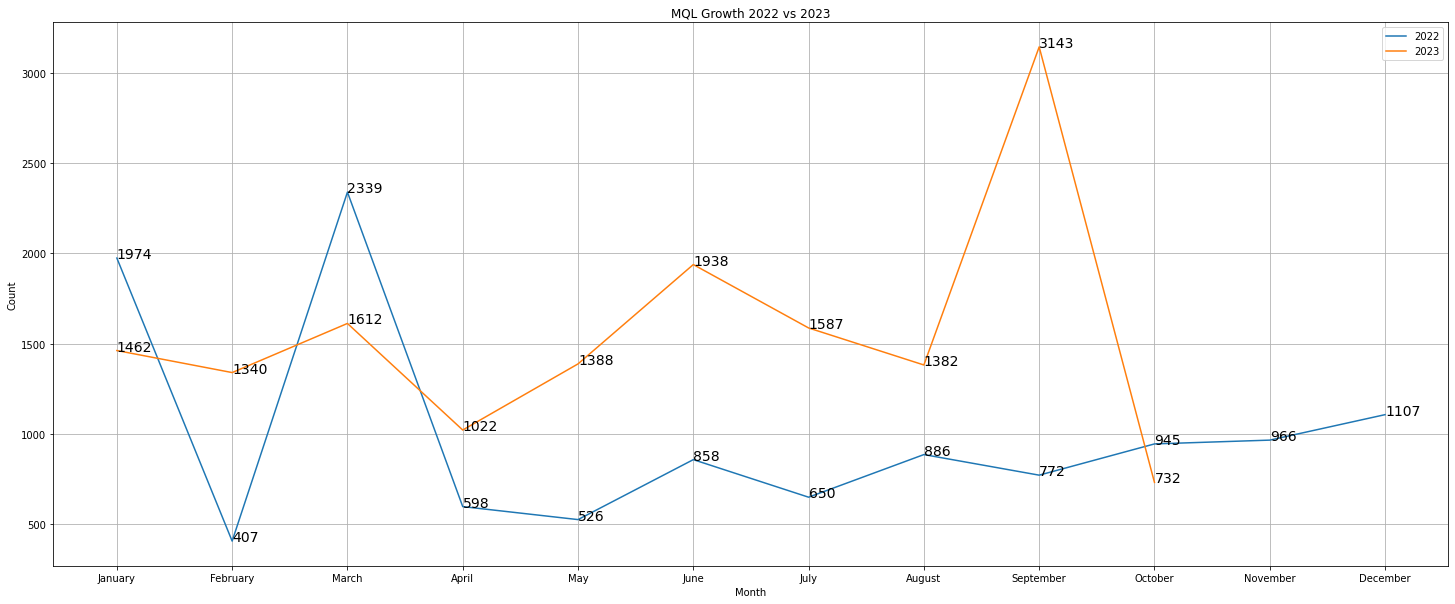

In [30]:
import calendar
x_axis = [calendar.month_name[i+1] for i in range(12)]

y_axis_2022_odoo = []
for i in range(0,12):
    try:
        y_axis_2022_odoo.append(date_groupby_mql_2022.values[i][0])
    except:
        y_axis_2022_odoo.append(None)


y_axis_2023_odoo = []
for i in range(0,12):
    try:
        y_axis_2023_odoo.append(date_groupby_mql_2023.values[i][0])
    except:
        y_axis_2023_odoo.append(None)

import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
plt.title("MQL Growth 2022 vs 2023")
plt.grid()
plt.plot(x_axis,y_axis_2022_odoo, label="2022")
for i in range(len(x_axis)):
    plt.text(i,y_axis_2022_odoo[i] if y_axis_2022_odoo[i] else 0 ,(y_axis_2022_odoo[i]),size=14)

plt.plot(x_axis,y_axis_2023_odoo, label="2023")
for i in range(len(x_axis)):
    plt.text(i,y_axis_2023_odoo[i] if y_axis_2023_odoo[i] else 0,(y_axis_2023_odoo[i]),size=14)
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend()
plt.show()

NEW CUSTOMER

Get data

In [26]:
res = search_from_odoo(
    'res.partner',
    [
        ['email', 'not like', 'smsperkasa']
    ],
    ['name', 'phone', 'email', 'become_customer_date', 'sale_order_count', 'is_company']
)
all_contacts_df = pd.DataFrame(res)
all_contacts_df['become_customer_date'] = pd.to_datetime(all_contacts_df['become_customer_date'], errors='coerce')

Summary

All

In [27]:
date_range_2023 = all_contacts_df[(all_contacts_df['become_customer_date'] >= '2023-01-01') & (all_contacts_df['become_customer_date'] <= '2023-12-31')]
date_groupby_new_cust_2023 = date_range_2023.groupby([date_range_2023['become_customer_date'].dt.month.rename('month')]).agg({'count'})['become_customer_date']

date_range_2022 = all_contacts_df[(all_contacts_df['become_customer_date'] >= '2022-01-01') & (all_contacts_df['become_customer_date'] <= '2022-12-31')]
date_groupby_new_cust_2022 = date_range_2022.groupby([date_range_2022['become_customer_date'].dt.month.rename('month')]).agg({'count'})['become_customer_date']

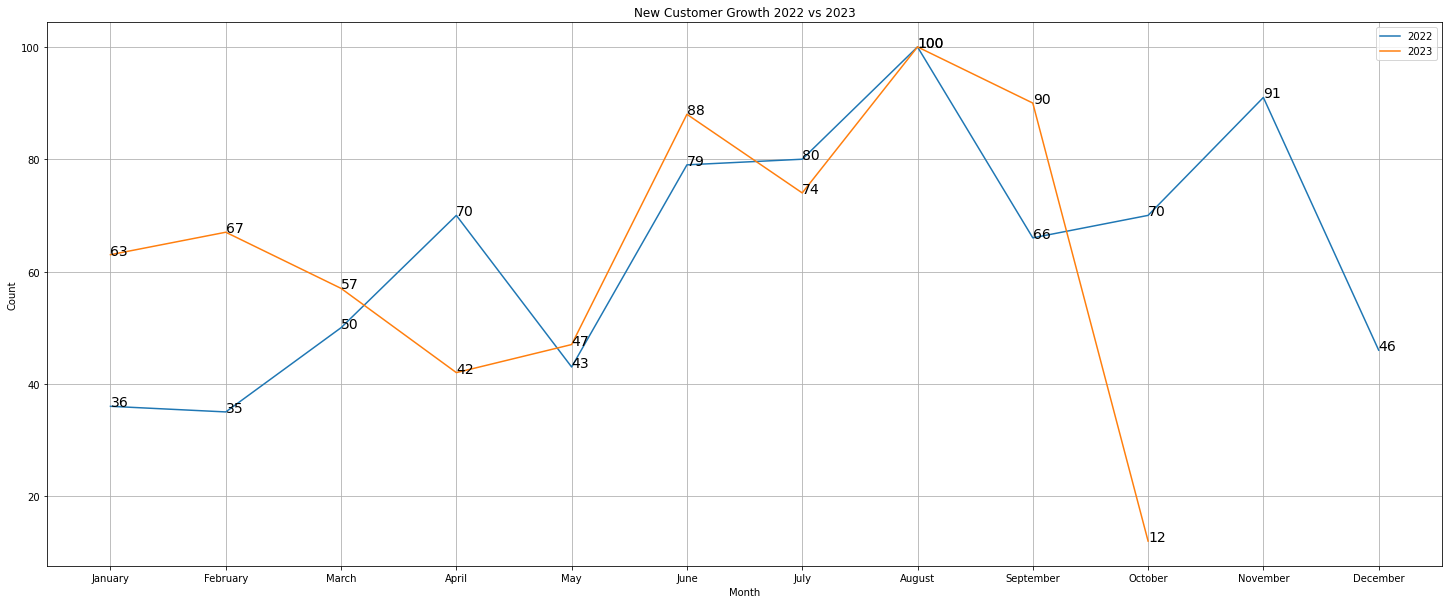

In [28]:
x_axis = [calendar.month_name[i+1] for i in range(12)]

y_axis_2022_odoo = []
for i in range(0,12):
    try:
        y_axis_2022_odoo.append(date_groupby_new_cust_2022.values[i][0])
    except:
        y_axis_2022_odoo.append(None)


y_axis_2023_odoo = []
for i in range(0,12):
    try:
        y_axis_2023_odoo.append(date_groupby_new_cust_2023.values[i][0])
    except:
        y_axis_2023_odoo.append(None)

import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
plt.title("New Customer Growth 2022 vs 2023")
plt.grid()
plt.plot(x_axis,y_axis_2022_odoo, label="2022")
for i in range(len(x_axis)):
    plt.text(i,y_axis_2022_odoo[i] if y_axis_2022_odoo[i] else 0 ,(y_axis_2022_odoo[i]),size=14)

plt.plot(x_axis,y_axis_2023_odoo, label="2023")
for i in range(len(x_axis)):
    plt.text(i,y_axis_2023_odoo[i] if y_axis_2023_odoo[i] else 0,(y_axis_2023_odoo[i]),size=14)
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend()
plt.show()

In [64]:
convertion_rate_2022 = date_groupby_new_cust_2022 / date_groupby_mql_2022 * 100
convertion_rate_2023 = date_groupby_new_cust_2023 / date_groupby_mql_2023 * 100

In [81]:
date_groupby_new_cust_2022_csv = date_groupby_new_cust_2022.reset_index()
date_groupby_mql_2022_csv = date_groupby_mql_2022.reset_index()
convertion_rate_2022_csv = convertion_rate_2022.reset_index()
date_groupby_new_cust_2022_csv.rename(columns={
    'count': 'new_customer'
}, inplace=True)

date_groupby_mql_2022_csv.rename(columns={
    'count': 'mql'
}, inplace=True)

convertion_rate_2022_csv.rename(columns={
    'count': 'convertion_rate'
}, inplace=True)

date_groupby_new_cust_2023_csv = date_groupby_new_cust_2023.reset_index()
date_groupby_mql_2023_csv = date_groupby_mql_2023.reset_index()
convertion_rate_2023_csv = convertion_rate_2023.reset_index()
date_groupby_new_cust_2023_csv.rename(columns={
    'count': 'new_customer'
}, inplace=True)

date_groupby_mql_2023_csv.rename(columns={
    'count': 'mql'
}, inplace=True)

convertion_rate_2023_csv.rename(columns={
    'count': 'convertion_rate'
}, inplace=True)

In [87]:
csv_2022 = date_groupby_new_cust_2022_csv.merge(date_groupby_mql_2022_csv, on='month').merge(convertion_rate_2022_csv, on='month')
csv_2023 = date_groupby_new_cust_2023_csv.merge(date_groupby_mql_2023_csv, on='month').merge(convertion_rate_2023_csv, on='month')

In [88]:
with pd.ExcelWriter("/Users/bcw-003/Downloads/mql_cust.xlsx") as writer:
    csv_2022.to_excel(writer, sheet_name='2022', index=False)
    csv_2023.to_excel(writer, sheet_name='2023', index=False)

In [70]:
date_groupby_new_cust_2022[:9].sum()

count    349
dtype: int64

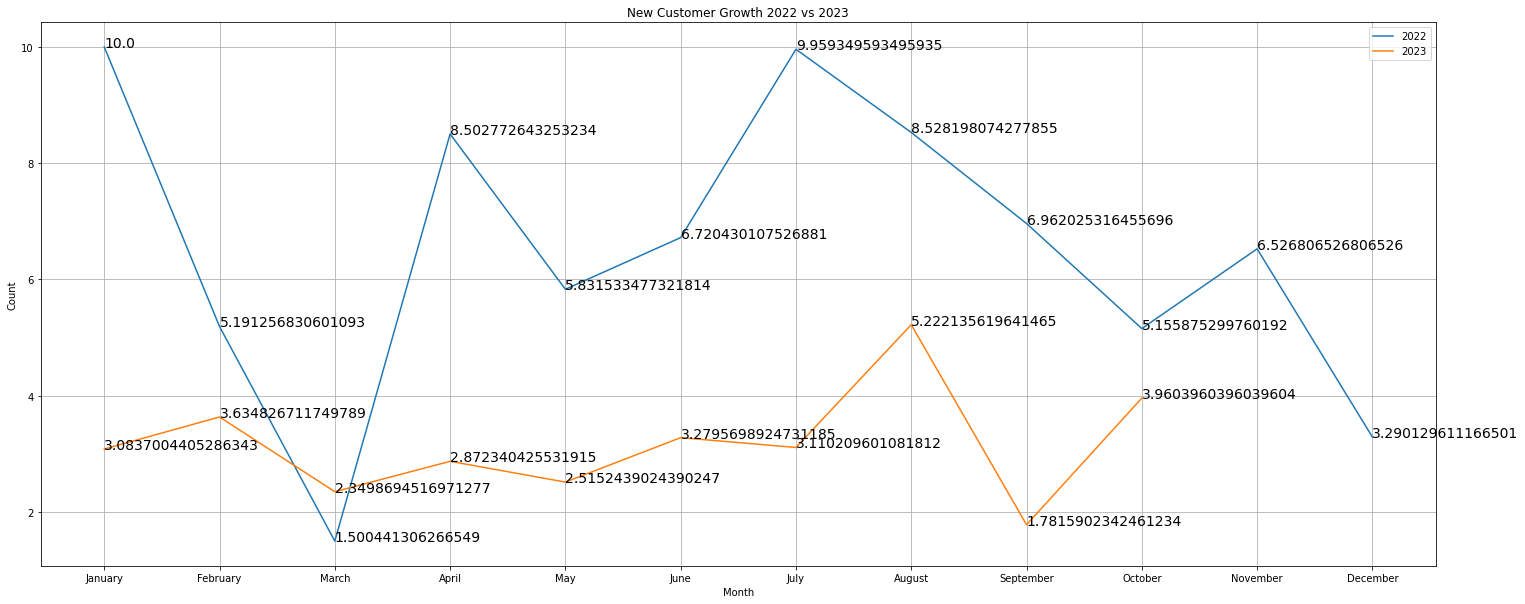

In [65]:
x_axis = [calendar.month_name[i+1] for i in range(12)]

y_axis_2022_odoo = []
for i in range(0,12):
    try:
        y_axis_2022_odoo.append(convertion_rate_2022.values[i][0])
    except:
        y_axis_2022_odoo.append(None)


y_axis_2023_odoo = []
for i in range(0,12):
    try:
        y_axis_2023_odoo.append(convertion_rate_2023.values[i][0])
    except:
        y_axis_2023_odoo.append(None)

import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
plt.title("New Customer Growth 2022 vs 2023")
plt.grid()
plt.plot(x_axis,y_axis_2022_odoo, label="2022")
for i in range(len(x_axis)):
    plt.text(i,y_axis_2022_odoo[i] if y_axis_2022_odoo[i] else 0 ,(y_axis_2022_odoo[i]),size=14)

plt.plot(x_axis,y_axis_2023_odoo, label="2023")
for i in range(len(x_axis)):
    plt.text(i,y_axis_2023_odoo[i] if y_axis_2023_odoo[i] else 0,(y_axis_2023_odoo[i]),size=14)
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend()
plt.show()

In [63]:
x

,count
month,
1,3.083700
2,3.634827
3,2.349869
4,2.872340
5,2.515244
6,3.279570
7,3.110210
8,5.222136
9,1.781590


Company

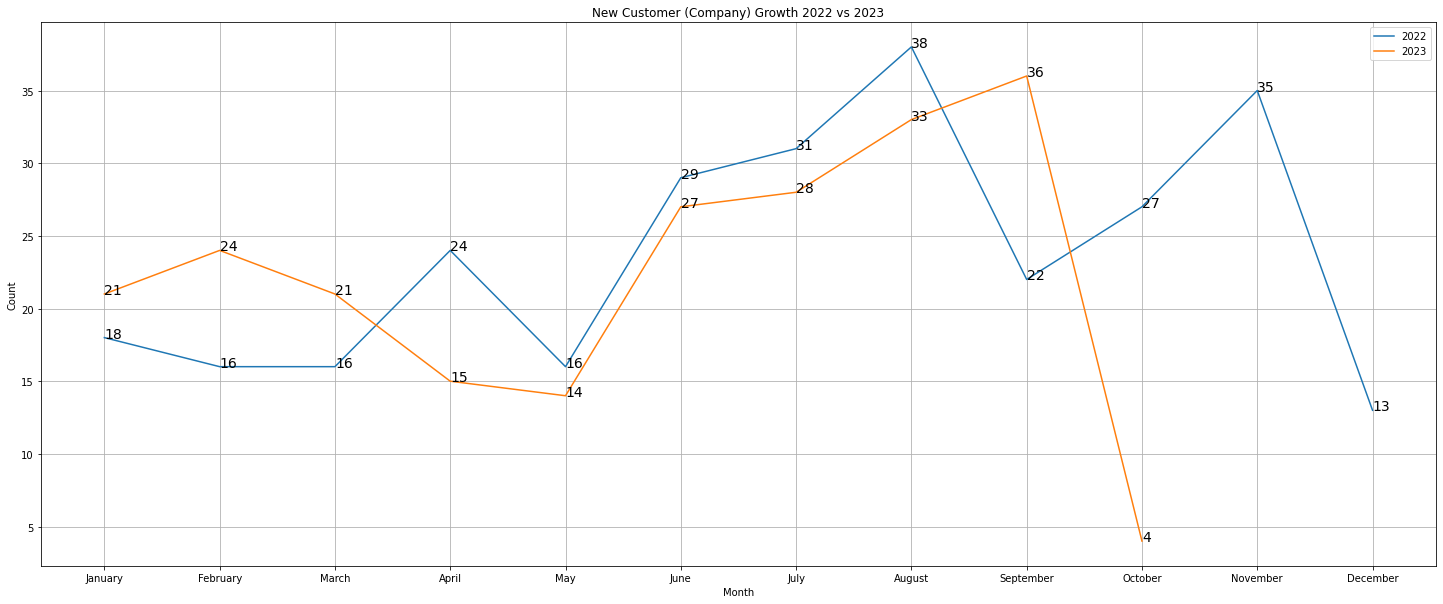

In [31]:
date_range_2023 = all_contacts_df[(all_contacts_df['become_customer_date'] >= '2023-01-01') & (all_contacts_df['become_customer_date'] <= '2023-12-31') & (all_contacts_df['is_company'] == True)]
date_groupby_new_cust_2023 = date_range_2023.groupby([date_range_2023['become_customer_date'].dt.month.rename('month')]).agg({'count'})['become_customer_date']

date_range_2022 = all_contacts_df[(all_contacts_df['become_customer_date'] >= '2022-01-01') & (all_contacts_df['become_customer_date'] <= '2022-12-31') & (all_contacts_df['is_company'] == True)]
date_groupby_new_cust_2022 = date_range_2022.groupby([date_range_2022['become_customer_date'].dt.month.rename('month')]).agg({'count'})['become_customer_date']

x_axis = [calendar.month_name[i+1] for i in range(12)]

y_axis_2022_odoo = []
for i in range(0,12):
    try:
        y_axis_2022_odoo.append(date_groupby_new_cust_2022.values[i][0])
    except:
        y_axis_2022_odoo.append(None)


y_axis_2023_odoo = []
for i in range(0,12):
    try:
        y_axis_2023_odoo.append(date_groupby_new_cust_2023.values[i][0])
    except:
        y_axis_2023_odoo.append(None)

import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
plt.title("New Customer (Company) Growth 2022 vs 2023")
plt.grid()
plt.plot(x_axis,y_axis_2022_odoo, label="2022")
for i in range(len(x_axis)):
    plt.text(i,y_axis_2022_odoo[i] if y_axis_2022_odoo[i] else 0 ,(y_axis_2022_odoo[i]),size=14)

plt.plot(x_axis,y_axis_2023_odoo, label="2023")
for i in range(len(x_axis)):
    plt.text(i,y_axis_2023_odoo[i] if y_axis_2023_odoo[i] else 0,(y_axis_2023_odoo[i]),size=14)
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend()
plt.show()

Individu

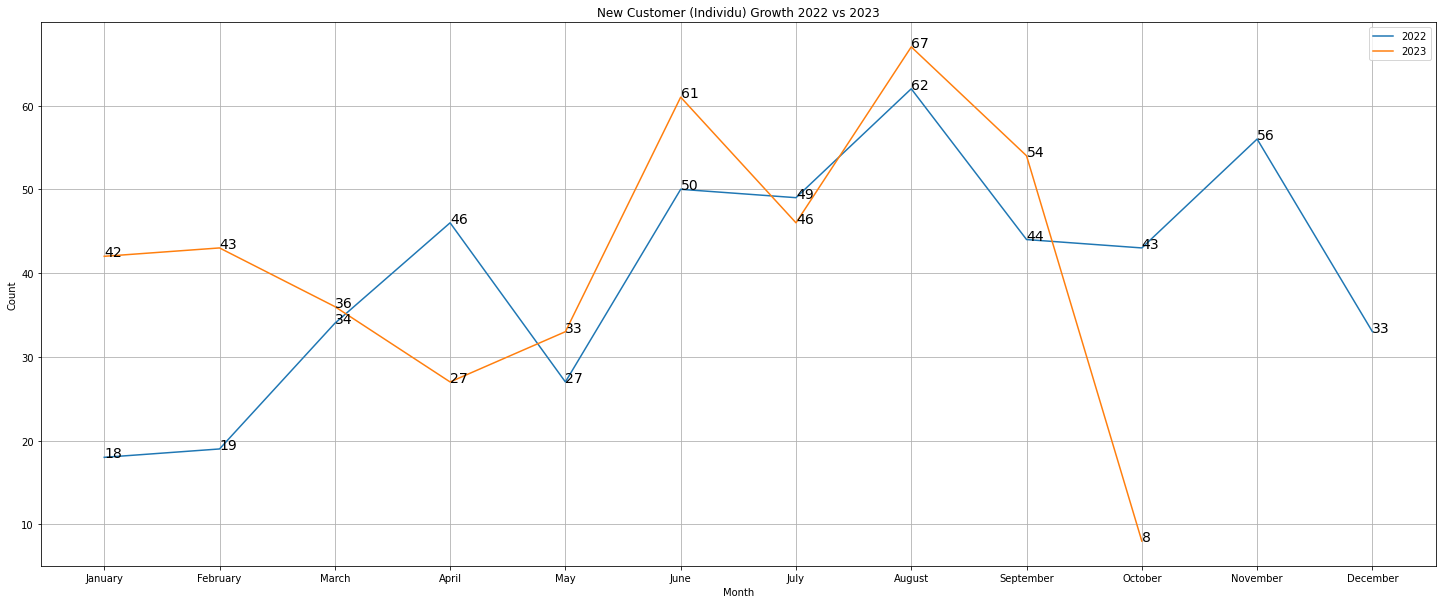

In [32]:
date_range_2023 = all_contacts_df[(all_contacts_df['become_customer_date'] >= '2023-01-01') & (all_contacts_df['become_customer_date'] <= '2023-12-31') & (all_contacts_df['is_company'] == False)]
date_groupby_new_cust_2023 = date_range_2023.groupby([date_range_2023['become_customer_date'].dt.month.rename('month')]).agg({'count'})['become_customer_date']

date_range_2022 = all_contacts_df[(all_contacts_df['become_customer_date'] >= '2022-01-01') & (all_contacts_df['become_customer_date'] <= '2022-12-31') & (all_contacts_df['is_company'] == False)]
date_groupby_new_cust_2022 = date_range_2022.groupby([date_range_2022['become_customer_date'].dt.month.rename('month')]).agg({'count'})['become_customer_date']

x_axis = [calendar.month_name[i+1] for i in range(12)]

y_axis_2022_odoo = []
for i in range(0,12):
    try:
        y_axis_2022_odoo.append(date_groupby_new_cust_2022.values[i][0])
    except:
        y_axis_2022_odoo.append(None)


y_axis_2023_odoo = []
for i in range(0,12):
    try:
        y_axis_2023_odoo.append(date_groupby_new_cust_2023.values[i][0])
    except:
        y_axis_2023_odoo.append(None)

import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
plt.title("New Customer (Individu) Growth 2022 vs 2023")
plt.grid()
plt.plot(x_axis,y_axis_2022_odoo, label="2022")
for i in range(len(x_axis)):
    plt.text(i,y_axis_2022_odoo[i] if y_axis_2022_odoo[i] else 0 ,(y_axis_2022_odoo[i]),size=14)

plt.plot(x_axis,y_axis_2023_odoo, label="2023")
for i in range(len(x_axis)):
    plt.text(i,y_axis_2023_odoo[i] if y_axis_2023_odoo[i] else 0,(y_axis_2023_odoo[i]),size=14)
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend()
plt.show()

INVOICE

Get data

In [56]:
from ast import literal_eval

In [90]:
def convert_list_str(arrList, idx):
    if arrList is not None:
        # arrList = literal_eval(strList)
        return arrList[idx]
    return None

In [110]:
res = search_from_odoo(
    'account.move',
    [
        ['move_type', '=', 'out_invoice'],
        ['state', '=', 'posted']
    ],
    ['name', 'amount_untaxed', 'partner_id', 'invoice_date']
)
all_invoices_df = pd.DataFrame(res)
all_invoices_df['invoice_date'] = pd.to_datetime(all_invoices_df['invoice_date'], errors='coerce')
all_invoices_df['partner_id_id'] = all_invoices_df.apply(lambda x: convert_list_str(x.partner_id, 0), axis=1)

Summary

In [136]:
date_range_2023 = all_invoices_df[(all_invoices_df['invoice_date'] >= '2023-01-01') & (all_invoices_df['invoice_date'] <= '2023-12-31')]
count_inv_2023 = date_range_2023.groupby([date_range_2023['invoice_date'].dt.month.rename('month')]).agg({'nunique'})['name']
rev_inv_2023 = date_range_2023.groupby([date_range_2023['invoice_date'].dt.month.rename('month')]).agg({'sum'})['amount_untaxed']
count_cust_2023 = date_range_2023.groupby([date_range_2023['invoice_date'].dt.month.rename('month')]).agg({'nunique'})['partner_id_id']

date_range_2022 = all_invoices_df[(all_invoices_df['invoice_date'] >= '2022-01-01') & (all_invoices_df['invoice_date'] <= '2022-12-31')]
count_inv_2022 = date_range_2022.groupby([date_range_2022['invoice_date'].dt.month.rename('month')]).agg({'nunique'})['name']
rev_inv_2022 = date_range_2022.groupby([date_range_2022['invoice_date'].dt.month.rename('month')]).agg({'sum'})['amount_untaxed']
count_cust_2022 = date_range_2022.groupby([date_range_2022['invoice_date'].dt.month.rename('month')]).agg({'nunique'})['partner_id_id']

/var/folders/w3/b14k9y695c912pkmbdrg1k900000gn/T/ipykernel_2907/247277788.py:2: FutureWarning: ['partner_id'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  count_inv_2023 = date_range_2023.groupby([date_range_2023['invoice_date'].dt.month.rename('month')]).agg({'nunique'})['name']
/var/folders/w3/b14k9y695c912pkmbdrg1k900000gn/T/ipykernel_2907/247277788.py:3: FutureWarning: ['invoice_date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  rev_inv_2023 = date_range_2023.groupby([date_range_2023['invoice_date'].dt.month.rename('month')]).agg({'sum'})['amount_untaxed']
/var/folders/w3/b14k9y695c912pkmbdrg1k900000gn/T/ipykernel_2907/247277788.py:4: FutureWarning: ['partner_id'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these

In [164]:
grouped_data_2022 = date_range_2022.groupby(date_range_2022['invoice_date'].dt.month.rename('month')).agg({'nunique', 'sum'})
grouped_data_2023 = date_range_2023.groupby(date_range_2023['invoice_date'].dt.month.rename('month')).agg({'nunique', 'sum'})

/var/folders/w3/b14k9y695c912pkmbdrg1k900000gn/T/ipykernel_2907/3323618576.py:1: FutureWarning: ['partner_id', 'invoice_date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  grouped_data_2022 = date_range_2022.groupby(date_range_2022['invoice_date'].dt.month.rename('month')).agg({'nunique', 'sum'})
/var/folders/w3/b14k9y695c912pkmbdrg1k900000gn/T/ipykernel_2907/3323618576.py:2: FutureWarning: ['partner_id', 'invoice_date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  grouped_data_2023 = date_range_2023.groupby(date_range_2023['invoice_date'].dt.month.rename('month')).agg({'nunique', 'sum'})


In [220]:
inv_cust_2022 = count_inv_2022 / count_cust_2022
# avg_inv_2022 = rev_inv_2022 / count_inv_2022
avg_inv_2022 = grouped_data_2022['amount_untaxed']['sum'] / grouped_data_2022['name']['nunique']
avg_inv_2022_df = pd.DataFrame(avg_inv_2022)

inv_cust_2023 = count_inv_2023 / count_cust_2023
# avg_inv_2023 = rev_inv_2023 / count_inv_2023
avg_inv_2023 = grouped_data_2023['amount_untaxed']['sum'] / grouped_data_2023['name']['nunique']
avg_inv_2023_df = pd.DataFrame(avg_inv_2023)

In [221]:
count_inv_2023_df = count_inv_2023.reset_index()
rev_inv_2023_df = rev_inv_2023.reset_index()
count_cust_2023_df = count_cust_2023.reset_index()
inv_cust_2023_df = inv_cust_2023.reset_index()
avg_inv_2023_df = avg_inv_2023_df.reset_index()
count_inv_2023_df.rename(columns={
    'nunique': 'count_inv'
}, inplace=True)
rev_inv_2023_df.rename(columns={
    'sum': 'total_rev'
}, inplace=True)
count_cust_2023_df.rename(columns={
    'nunique': 'count_cust'
}, inplace=True)
inv_cust_2023_df.rename(columns={
    'nunique': 'inv_per_cust'
}, inplace=True)
avg_inv_2023_df.rename(columns={
    0: 'avg_inv'
}, inplace=True)

count_inv_2022_df = count_inv_2022.reset_index()
rev_inv_2022_df = rev_inv_2022.reset_index()
count_cust_2022_df = count_cust_2022.reset_index()
inv_cust_2022_df = inv_cust_2022.reset_index()
avg_inv_2022_df = avg_inv_2022_df.reset_index()
count_inv_2022_df.rename(columns={
    'nunique': 'count_inv'
}, inplace=True)
rev_inv_2022_df.rename(columns={
    'sum': 'total_rev'
}, inplace=True)
count_cust_2022_df.rename(columns={
    'nunique': 'count_cust'
}, inplace=True)
inv_cust_2022_df.rename(columns={
    'nunique': 'inv_per_cust'
}, inplace=True)
avg_inv_2022_df.rename(columns={
    0: 'avg_inv'
}, inplace=True)

In [224]:
inv_2022_csv = count_inv_2022_df.merge(rev_inv_2022_df, on='month').merge(count_cust_2022_df, on='month').merge(inv_cust_2022_df, on='month').merge(avg_inv_2022_df, on='month')
inv_2023_csv = count_inv_2023_df.merge(rev_inv_2023_df, on='month').merge(count_cust_2023_df, on='month').merge(inv_cust_2023_df, on='month').merge(avg_inv_2023_df, on='month')

In [227]:
inv_2023_csv

,month,count_inv,total_rev,count_cust,inv_per_cust,avg_inv
0,1,212,4.847994e+09,85,2.494118,2.286790e+07
1,2,209,8.402919e+09,100,2.090000,4.020535e+07
2,3,193,3.857967e+09,77,2.506494,1.998947e+07
3,4,130,2.978549e+09,58,2.241379,2.291191e+07
4,5,177,4.728614e+09,69,2.565217,2.671533e+07
5,6,266,8.366906e+09,102,2.607843,3.145453e+07
6,7,268,4.867810e+09,110,2.436364,1.816347e+07
7,8,341,5.523704e+09,124,2.750000,1.619855e+07
8,9,283,5.621589e+09,106,2.669811,1.986427e+07
9,10,41,1.109317e+09,29,1.413793,2.705651e+07


In [226]:
with pd.ExcelWriter("/Users/bcw-003/Downloads/cust_inv.xlsx") as writer:
    inv_2022_csv.to_excel(writer, sheet_name='2022', index=False)
    inv_2023_csv.to_excel(writer, sheet_name='2023', index=False)

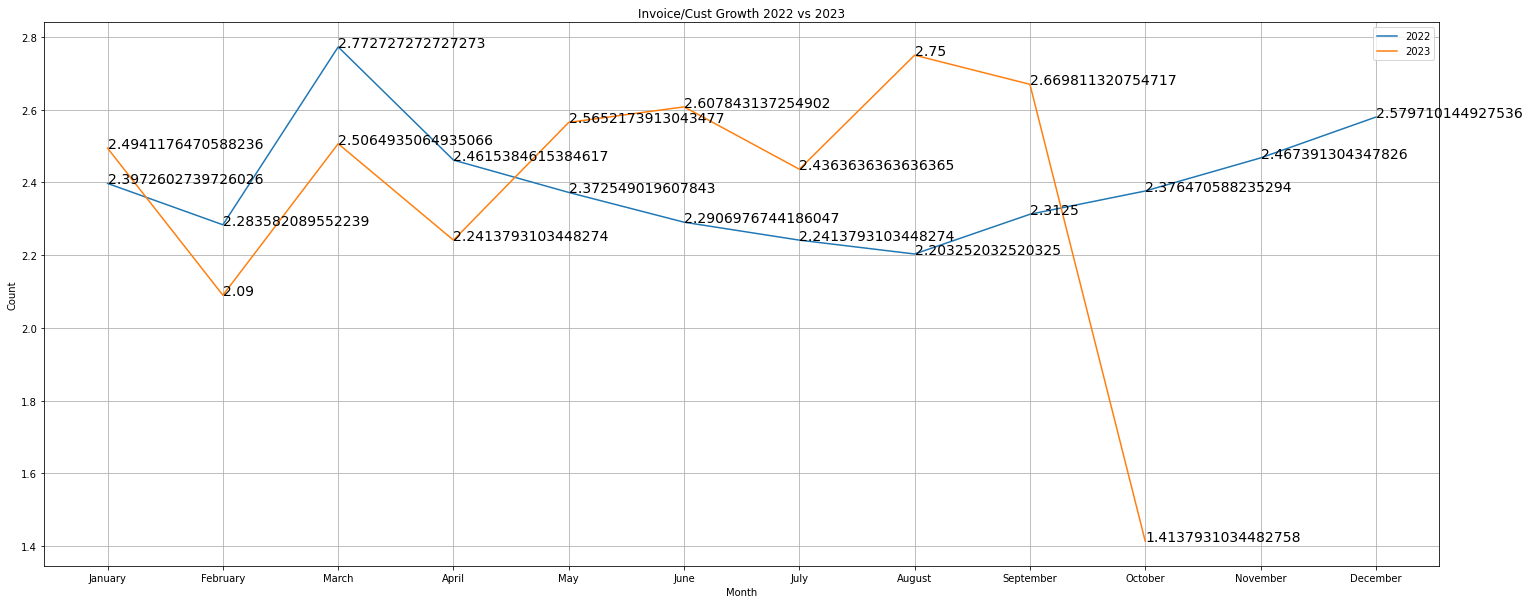

In [139]:
x_axis = [calendar.month_name[i+1] for i in range(12)]

y_axis_2022_odoo = []
for i in range(0,12):
    try:
        y_axis_2022_odoo.append(inv_cust_2022.values[i][0])
    except:
        y_axis_2022_odoo.append(None)


y_axis_2023_odoo = []
for i in range(0,12):
    try:
        y_axis_2023_odoo.append(inv_cust_2023.values[i][0])
    except:
        y_axis_2023_odoo.append(None)

import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
plt.title("Invoice/Cust Growth 2022 vs 2023")
plt.grid()
plt.plot(x_axis,y_axis_2022_odoo, label="2022")
for i in range(len(x_axis)):
    plt.text(i,y_axis_2022_odoo[i] if y_axis_2022_odoo[i] else 0 ,(y_axis_2022_odoo[i]),size=14)

plt.plot(x_axis,y_axis_2023_odoo, label="2023")
for i in range(len(x_axis)):
    plt.text(i,y_axis_2023_odoo[i] if y_axis_2023_odoo[i] else 0,(y_axis_2023_odoo[i]),size=14)
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend()
plt.show()

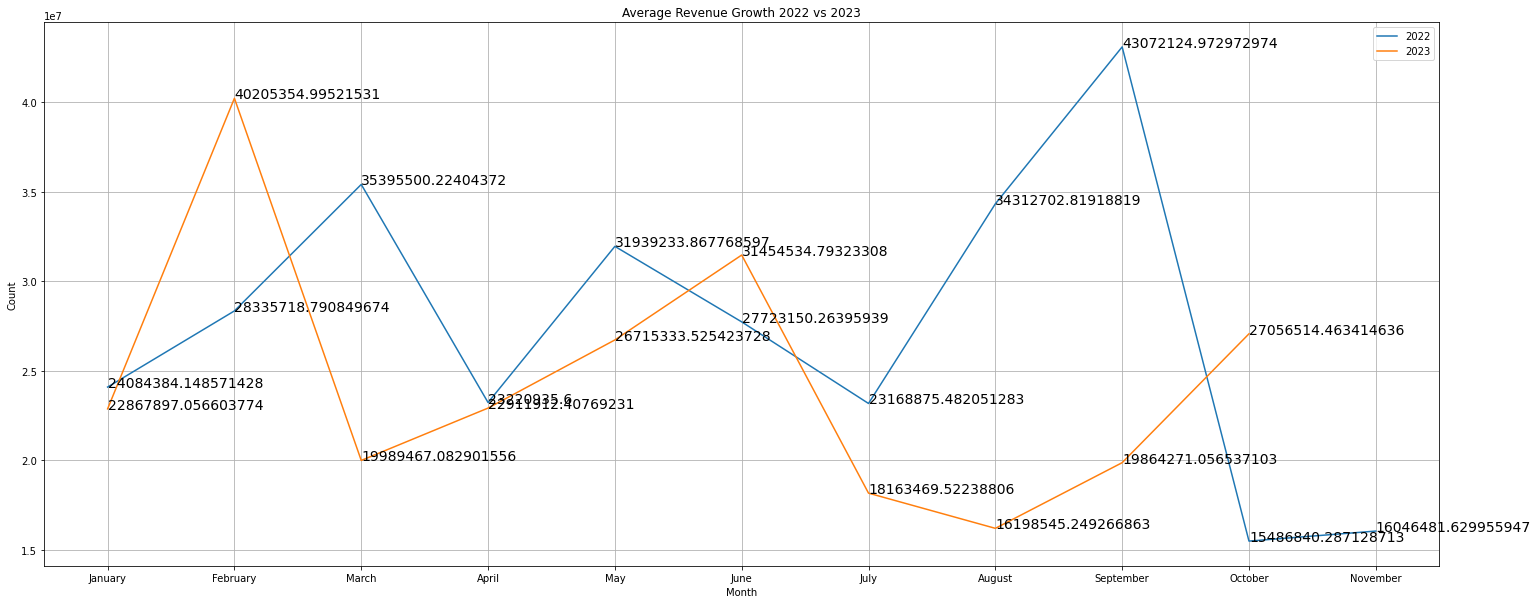

In [229]:
x_axis = [calendar.month_name[i] for i in range(12)]

y_axis_2022_odoo = []
for i in range(0,12):
    try:
        y_axis_2022_odoo.append(avg_inv_2022[i])
    except:
        y_axis_2022_odoo.append(None)


y_axis_2023_odoo = []
for i in range(0,12):
    try:
        y_axis_2023_odoo.append(avg_inv_2023[i])
    except:
        y_axis_2023_odoo.append(None)

import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
plt.title("Average Revenue Growth 2022 vs 2023")
plt.grid()
plt.plot(x_axis,y_axis_2022_odoo, label="2022")
for i in range(len(x_axis)):
    plt.text(i,y_axis_2022_odoo[i] if y_axis_2022_odoo[i] else 0 ,(y_axis_2022_odoo[i]),size=14)

plt.plot(x_axis,y_axis_2023_odoo, label="2023")
for i in range(len(x_axis)):
    plt.text(i,y_axis_2023_odoo[i] if y_axis_2023_odoo[i] else 0,(y_axis_2023_odoo[i]),size=14)
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend()
plt.show()

In [228]:
avg_inv_2023

month
1     2.286790e+07
2     4.020535e+07
3     1.998947e+07
4     2.291191e+07
5     2.671533e+07
6     3.145453e+07
7     1.816347e+07
8     1.619855e+07
9     1.986427e+07
10    2.705651e+07
dtype: float64